# Commissioning Cool Star RV Precision
This notebook is designed to test the APOGEE instruments RV precision for cools stars from commissioning data. Of particular interest to Milky Way Mapper's SRD are Red Giants, subgiants, and M dwarfs. This is part of answering Jira Ticket: https://jira.sdss.org/browse/COMMWM-31

In [1]:
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table,vstack
import astropy.units as u
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import os.path as path
import numpy as np
from scipy import stats
%matplotlib inline

In [2]:
def exp2h(exps):
    #Scale the hmag based on t = (1 hour)*10^(0.4*(H-11))
    #Take number of 15 minute exposures and convert to H.      
    hmag = 2.5*np.log10(exps/4.0) + 11
    return(hmag)

def h2exp(hmag,sn=100,exptime=15.0):   
    '''
    This function takes in a hmag and given signal to noise and spits back the required time. Based on
    Hmag = 11 at S/N 100 in an hour.
    '''
    #Scale the hmag based on t = (1 hour)*10^(0.4*(H-11))
    #Then I cut it up into 15 minute exposures.      
    time = 60*(sn**2/100.0**2)*10**(0.4*(hmag-11))
    nexp = np.array(np.round(time / exptime)) 
    #Min value is 1
    nexp[(nexp == 0)] = 1
    #Set Nan's to nan  
    nexp[np.isnan(hmag)] = np.nan
    
    #for i in range(len(hmag)):
    #    print(hmag[i],time[i],nexp[i])    
    return(nexp)
def h2sn(hmag,exptime=15.0,zeropoint=11):
    '''
    This function takes in a hmag and given exposure time in minutes. Based on
    Hmag = 11 at S/N 100 in an hour.
    '''
    sn = np.sqrt((exptime/60)*100**2 * 10**(0.4*(zeropoint-hmag)))
    return(sn)
def fit_h2sn(hmag,zeropoint):
    '''
    This function is used to fit the zeropoint of the h2sn fuction. Based on
    Hmag = 11 at S/N 100 in an hour.
    '''
    exptime = 15 
    sn = np.sqrt((exptime/60)*100**2 * 10**(0.4*(zeropoint-hmag)))
    return(sn)

## Load Daily Reductions

In [3]:
allStar_tab = Table.read('allStar-daily-apo25m.fits',hdu=1)
allStar_tab[0:4]

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39
1618,2M21241108+0023308,apStar-daily-apo25m-2M21241108+0023308-59159.fits,apogee/spectro/redux/daily/stars/apo25m/97/97480/apStar-daily-apo25m-2M21241108+0023308-59159.fits,59159,59159,59159,apo25m,daily,97480,0.0,321.04593,0.3909809,53.05351280485398,-33.167238075726566,12.12,0.023,11.537,0.023,11.304,0.021,,-60.509,-220.049,,0,0,0,0,0,0,4376582145,2690938233764582656,20.2725,0.0834379,-60.5094,0.0906221,-220.049,0.0792318,14.8548,0.000557,16.2632,0.004615,13.6917,0.00136,128,mwm_snc_100pc,MWM_SNC_100PC,1,1,1,2052,"BRIGHT_NEIGHBOR,PERSIST_LOW",0,,30.28239,0.0,0.18429226,0.18429226,1.571745,3763.678,18.377628,4.3854876,0.05833076,-1.9674665,0.05243584,nan,nan,1,295.0,0.0,2020-11-07 02:19:55.794551-07
1678,2M21261537-0024200,apStar-daily-apo25m-2M21261537-0024200-59159.fits,apogee/spectro/redux/daily/stars/apo25m/99/99529/apStar-daily-apo25m-2M21261537-0024200-59159.fits,59159,59159,59159,apo25m,daily,99529,0.0,321.56401,-0.4056365,52.59353904643508,-34.03685586210795,10.792,0.026,10.126,0.026,9.998,0.019,,-0.59,-3.628,,0,0,0,0,0,0,4367804592,2687626225567929088,0.189265,0.0379153,-0.590273,0.0651367,-3.62772,0.06411,12.6716,0.000348,13.3485,0.003389,11.8954,0.001421,8388608,mwm_tessrgb_core,MWM_TESSRGB,1,1,1,1048576,RV_SUSPECT,0,,-61.26199,0.0,0.0384314,0.0384314,4.3960505,4459.9834,7.8395667,2.9814246,0.02918164,-1.161864,0.009674512,nan,nan,1,182.0,0.0,2020-11-07 02:26:30.500618-07
1735,2M21281151-0016118,apStar-daily-apo25m-2M21281151-0016118-59159.fits,apogee/spectro/redux/daily/stars/apo25m/99/99018/apStar-daily-apo25m-2M21281151-0016118-59159.fits,59159,59159,59159,apo25m,daily,99018,0.0,322.04797,-0.269952,53.05111720459024,-34.36761438361869,8.736,0.023,8.482,0.029,8.448,0.021,,-15.894,-8.581,,0,0,0,0,0,0,0,2687655156468282112,4.67141,0.0665871,-15.8935,0.0824865,-8.58075,0.0812393,9.6593,0.005308,9.92235,0.015016,9.25465,0.017866,2,None,MWM_TELLURIC,1,1,1,3145728,"RV_SUSPECT,MULTIPLE_SUSPECT",0,,-48.64175,0.0,0.088617235,0.088617235,5.7514124,5847.032,20.018637,4.5242686,0.021310525,-1.227875,0.011583159,nan,nan,2,196.0,0.0,2020-11-07 02:31:44.800195-07
8944,2M00355216+0137248,,,59167,59167,59167,apo25m,daily,95501,0.0,8.967351,1.623559,114.88546952524845,-61.00467158261487,8.898,0.029,8.723,0.042,8.684,0.023,,-11.49,-2.225,,0,0,0,0,0,0,0,0,3.44975,0.0731237,-11.4896,0.160375,-2.22453,0.104461,9.47132,0.000257,9.66453,0.000852,9.1767,0.000698,2,None,MWM_TELLURIC,1,1,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,161.0,0.0,2020-11-14 18:27:05.05528-07


In [4]:
#allStar_tab[0]['VISIT_PK']

In [5]:
allStar_tab.columns

<TableColumns names=('pk','apogee_id','file','uri','starver','mjdbeg','mjdend','telescope','apred_vers','healpix','snr','ra','dec','glon','glat','jmag','jerr','hmag','herr','kmag','kerr','src_h','targ_pmra','targ_pmdec','targ_pm_src','apogee_target1','apogee_target2','apogee2_target1','apogee2_target2','apogee2_target3','apogee2_target4','catalogid','gaiadr2_sourceid','gaiadr2_plx','gaiadr2_plx_error','gaiadr2_pmra','gaiadr2_pmra_error','gaiadr2_pmdec','gaiadr2_pmdec_error','gaiadr2_gmag','gaiadr2_gerr','gaiadr2_bpmag','gaiadr2_bperr','gaiadr2_rpmag','gaiadr2_rperr','sdssv_apogee_target0','firstcarton','targflags','nvisits','ngoodvisits','ngoodrvs','starflag','starflags','andflag','andflags','vheliobary','vscatter','verr','vmederr','chisq','rv_teff','rv_tefferr','rv_logg','rv_loggerr','rv_feh','rv_feherr','rv_ccpfwhm','rv_autofwhm','n_components','meanfib','sigfib','created')>

In [6]:
allStar_tab['telescope'][1]

'apo25m'

## Limit to stars in APOGEE (not 1m)
#Only apo25m data

In [7]:
allStar2_tab = allStar_tab[allStar_tab['telescope'] == 'apo25m']

 ## Limit to stars with Greater than or equal to 3 visits

In [8]:
allStarSmall_tab = allStar2_tab[(allStar2_tab['ngoodvisits'] >= 3)]
allStarSmall_tab[0:4]

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39
4656,2M23421560-0015181,apStar-daily-apo25m-2M23421560-0015181-59164.fits,apogee/spectro/redux/daily/stars/apo25m/99/99066/apStar-daily-apo25m-2M23421560-0015181-59164.fits,59164,59159,59164,apo25m,daily,99066,0.0,355.56518,-0.2551324,88.36131267454833,-58.405079628542744,12.54,0.027,12.235,0.026,12.221,0.029,,25.91,-21.551,,0,0,0,0,0,0,4371154539,2642617927538972800,1.30253,0.0273859,25.9099,0.0429408,-21.5512,0.029881,13.5145,0.000277,13.8027,0.001285,13.0562,0.001401,0,ops_std_boss,,3,3,3,0,,0,,-137.10663,0.32701454,0.18880193,0.21584193,1.2556226,5943.546,27.710047,4.310734,0.031161323,-1.3980836,0.017599786,nan,nan,1,181.0,0.0,2020-11-12 06:44:09.059491-07
67030,2M13542575+1534066,,,59221,59218,59221,apo25m,daily,71720,0.0,208.60731,15.568502,357.80884061694246,71.358409282388,-9999.99,-9999.99,14.577,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,0,0,-1,0,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,4,4,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,281.0,0.0,2021-01-09 11:35:59.978521-07
67048,2M14031257+1522263,,,59221,59218,59221,apo25m,daily,72236,0.0,210.8024,15.373986,1.3893690683745064,69.60192922160017,-9999.99,-9999.99,14.093,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,0,0,-1,0,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,4,4,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,260.0,0.0,2021-01-09 11:43:14.374031-07
67057,2M14020853+1557167,,,59221,59218,59221,apo25m,daily,71723,0.0,210.53556,15.954658,2.2689054587459054,70.16021457239627,-9999.99,-9999.99,14.082,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,0,0,-1,0,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,4,4,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,250.00003,0.0,2021-01-09 11:47:06.258205-07


## Limit Analysis to Commissioning Data
The daily reductions include the plate observations. In order to focus on commissioning I will put a cutoff of December 1st, 2021 (SJD 59550)

In [9]:
allStarSmall_tab = allStarSmall_tab[allStarSmall_tab['mjdbeg'] > 59550]
allStarSmall_tab

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39
299324,2M13024797-0100578,apStar-daily-apo25m-2M13024797-0100578-59619.fits,apogee/spectro/redux/daily/stars/apo25m/100/100374/apStar-daily-apo25m-2M13024797-0100578-59619.fits,59619,59616,59619,apo25m,daily,100374,0.0,195.700091214,-1.01579426656,308.9356941583023,61.72336686083783,13.361,0.026,12.955,0.032,12.949,0.031,,-27.6554,-3.25352,,0,0,0,0,0,0,27021598146652694,3686017972256374784,0.717571,0.0363145,-27.6554,0.0805493,-3.25352,0.0405636,14.5601,0.00042,14.9327,0.00187,14.0194,0.001133,0,manual_fps_position_stars_10,,35,23,23,16,LOW_SNR,0,,-9.106792,1.0633738,0.22172877,0.50144464,0.8271611,5814.3906,35.693825,4.5341187,0.034337625,-0.76154524,0.018086363,nan,nan,1,236.0,0.0,2022-02-22 10:06:44.353745-07
299572,2M12572186-0022580,apStar-daily-apo25m-2M12572186-0022580-59619.fits,apogee/spectro/redux/daily/stars/apo25m/99/99348/apStar-daily-apo25m-2M12572186-0022580-59619.fits,59619,59616,59619,apo25m,daily,99348,0.0,194.341271993,-0.382915171912,306.13699841741897,62.451877032739105,12.077,0.023,11.587,0.023,11.461,0.019,,-7.97222,-6.85562,,0,0,0,0,0,0,27021598146654467,3688939855687940096,0.274455,0.0371459,-7.97222,0.0626958,-6.85562,0.0401201,13.4537,0.000253,13.9096,0.0009,12.8379,0.000885,0,manual_fps_position_stars_10,,35,32,32,1048592,"LOW_SNR,RV_SUSPECT",0,,26.342434,0.44286963,0.07828903,0.22511852,0.93301195,5858.7544,14.010206,4.1917253,0.014959641,-1.1394557,0.0077695516,nan,nan,1,263.0,0.0,2022-02-22 09:47:53.424899-07
301564,2M06004542+0103569,apStar-daily-apo25m-2M06004542+0103569-59624.fits,apogee/spectro/redux/daily/stars/apo25m/96/96128/apStar-daily-apo25m-2M06004542+0103569-59624.fits,59624,59596,59624,apo25m,daily,96128,0.0,90.1892341614,1.06605947654,206.1182040834712,-10.759756352849498,10.473,0.024,9.809,0.024,9.63,0.019,,1.2084,0.22377,,0,0,0,0,0,0,27021598079399209,3314878058523002624,0.527046,0.0379853,1.2084,0.0639275,0.22377,0.0649153,12.8327,0.000463,13.7271,0.001896,11.9072,0.000946,0,manual_fps_position_stars_10,,39,32,32,0,,0,,11.865717,0.10917081,0.019298855,0.05605017,1.2695699,5365.345,5.278832,3.852403,0.0069335103,-0.45086178,0.0027662646,nan,nan,1,55.999996,0.0,2022-02-22 09:21:54.535303-07
301747,2M07582366+0002410,apStar-daily-apo25m-2M07582366+0002410-59624.fits,apogee/spectro/redux/daily/stars/apo25m/98/98218/apStar-daily-apo25m-2M07582366+0002410-59624.fits,59624,59624,59624,apo25m,daily,98218,0.0,119.598751451,0.0451597381703,220.69975073401207,14.873837838516256,10.241,0.026,9.621,0.026,9.49,0.023,,-0.253931,1.74095,,0,0,0,0,0,0,27021598101052268,3084074972829902592,0.271298,0.0371117,-0.253931,0.0611276,1.74095,0.038983,11.9033,0.000209,12.5217,0.001424,11.1807,0.000755,0,manual_fps_position_stars_10,,13,13,13,0,,0,,35.514854,0.136104

## Versus visit SN


In [10]:
allVisit_tab = Table.read('allVisit-daily-apo25m.fits',hdu=1)
allVisit_tab[0:4]

apogee_id,target_id,apred_vers,file,uri,fiberid,plate,mjd,telescope,survey,field,programname,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,pmra,pmdec,pm_src,apogee_target1,apogee_target2,apogee_target3,apogee_target4,catalogid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,snr,starflag,starflags,dateobs,jd,starver,bc,vtype,vrel,vrelerr,vheliobary,chisq,rv_teff,rv_feh,rv_logg,xcorr_vrel,xcorr_vrelerr,xcorr_vheliobary,n_components,rv_components [3]
bytes28,bytes28,bytes15,bytes51,bytes126,int64,bytes15,int64,bytes16,bytes23,bytes32,bytes38,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,float32,int64,bytes84,bytes33,float64,bytes15,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64
2M02220212-0338201,2M02220212-0338201,daily,apVisit-daily-apo25m-15000-59146-300.fits,apogee/spectro/redux/daily/visit/apo25m/RM_XMM-LSS/15000/59146/apVisit-daily-apo25m-15000-59146-300.fits,300,15000,59146,apo25m,bhm-mwm,RM_XMM-LSS,RM,35.50888,-3.6389338,169.52759316288896,-58.06355149903226,13.295,0.025,12.735,0.033,12.67,0.026,,3.431,4.719,,0,0,0,0,4375928109,2.17874,0.0464038,3.43114,0.0723419,4.71943,0.0682235,14.7875,0.000526,15.33,0.004293,14.1112,0.002807,4096,mwm_rv_short-rm,MWM_RV_SHORT-RM,18.4572,2048,PERSIST_LOW,2020-10-24T07:47:36.830,2459146.83631,59257,-0.13250805,0,-10.902415,0.16487071,-11.034924,1.2064264,5181.7773,-0.3262988,5.0,-10.902415,0.09597971,-11.034924,1,0.0 .. 0.0
2M02213274-0349084,2M02213274-0349084,daily,apVisit-daily-apo25m-15000-59146-299.fits,apogee/spectro/redux/daily/visit/apo25m/RM_XMM-LSS/15000/59146/apVisit-daily-apo25m-15000-59146-299.fits,299,15000,59146,apo25m,bhm-mwm,RM_XMM-LSS,RM,35.386301,-3.819165,169.572505802635,-58.28007969588191,12.875,0.025,12.236,0.025,12.128,0.025,,-25.373,-31.65,,0,0,0,0,4375927825,3.44558,0.0432759,-25.3735,0.0658018,-31.6502,0.0635863,14.7431,0.000576,15.4871,0.002461,13.9162,0.001144,4096,mwm_rv_short-rm,MWM_RV_SHORT-RM,27.9258,2048,PERSIST_LOW,2020-10-24T07:47:36.830,2459146.83631,59257,-0.22528726,0,5.972559,0.11849262,5.7472715,1.2741638,4428.4023,-0.26866427,4.9999943,5.972559,0.091171816,5.7472715,1,0.0 .. 0.0
2M02211966-0340309,2M02211966-0340309,daily,apVisit-daily-apo25m-15000-59146-298.fits,apogee/spectro/redux/daily/visit/apo25m/RM_XMM-LSS/15000/59146/apVisit-daily-apo25m-15000-59146-298.fits,298,15000,59146,apo25m,bhm-mwm,RM_XMM-LSS,RM,35.331989,-3.6753994,169.31724344104438,-58.205541289206025,11.889,0.022,11.409,0.025,11.292,0.021,,11.024,-19.46,,0,0,0,0,4375927856,3.19721,0.0363958,11.0235,0.0512859,-19.46,0.0428646,13.4122,0.000416,13.9676,0.001936,12.7312,0.001702,4096,mwm_rv_short-rm,MWM_RV_SHORT-RM,41.6361,2048,PERSIST_LOW,2020-10-24T07:47:36.830,2459146.83631,59257,-0.22695984,0,25.819456,0.0671376,25.592497,1.6235095,5103.638,0.24680437,4.9482646,25.819456,0.09464131,25.592497,1,0.0 .. 0.0
2M02202790-0345252,2M02202790-0345252,daily,apVisit-daily-apo25m-15000-59146-297.fits,apogee/spectro/redux/daily/visit/apo25m/RM_XMM-LSS/15000/59146/apVisit-daily-apo25m-15000-59146-297.fits,297,15000,59146,apo25m,bhm-mwm,RM_XMM-LSS,RM,35.116413,-3.7570834,169.1044021472123,-58.406653179266804,11.954,0.022,11.424,0.023,11.316,0.023,,17.11,-7.125,,0,0,0,0,4375927717,0.705001,0.028864,17.1098,0.0432881,-7.12505,0.0423367,13.456,0.000305,13.9858,0.002169,12.7911,0.001004,8392704,mwm_rv_short-rm,"MWM_RV_SHORT-RM,MWM_TESSRGB",51.8188,2048,PERSIST_LOW,2020-10-24T07:47:36.830,2459146.83631,59257,-0.3486252,0,-35.199856,0.056607783,-35.54848,1.6400621,5205.686,-0.1875161,4.4665403,-35.199856,0.16232516,-35.54848,1,0.0 .. 0.0


In [11]:
allVisit_tab.columns

<TableColumns names=('apogee_id','target_id','apred_vers','file','uri','fiberid','plate','mjd','telescope','survey','field','programname','ra','dec','glon','glat','jmag','jerr','hmag','herr','kmag','kerr','src_h','pmra','pmdec','pm_src','apogee_target1','apogee_target2','apogee_target3','apogee_target4','catalogid','gaiadr2_plx','gaiadr2_plx_error','gaiadr2_pmra','gaiadr2_pmra_error','gaiadr2_pmdec','gaiadr2_pmdec_error','gaiadr2_gmag','gaiadr2_gerr','gaiadr2_bpmag','gaiadr2_bperr','gaiadr2_rpmag','gaiadr2_rperr','sdssv_apogee_target0','firstcarton','targflags','snr','starflag','starflags','dateobs','jd','starver','bc','vtype','vrel','vrelerr','vheliobary','chisq','rv_teff','rv_feh','rv_logg','xcorr_vrel','xcorr_vrelerr','xcorr_vheliobary','n_components','rv_components')>

In [12]:
allVisit_tab[allVisit_tab['catalogid']== 4371154539]

apogee_id,target_id,apred_vers,file,uri,fiberid,plate,mjd,telescope,survey,field,programname,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,pmra,pmdec,pm_src,apogee_target1,apogee_target2,apogee_target3,apogee_target4,catalogid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,snr,starflag,starflags,dateobs,jd,starver,bc,vtype,vrel,vrelerr,vheliobary,chisq,rv_teff,rv_feh,rv_logg,xcorr_vrel,xcorr_vrelerr,xcorr_vheliobary,n_components,rv_components [3]
bytes28,bytes28,bytes15,bytes51,bytes126,int64,bytes15,int64,bytes16,bytes23,bytes32,bytes38,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,float32,int64,bytes84,bytes33,float64,bytes15,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64
2M23421560-0015181,2M23421560-0015181,daily,apVisit-daily-apo25m-15033-59159-181.fits,apogee/spectro/redux/daily/visit/apo25m/AQM_354.46_-00.45/15033/59159/apVisit-daily-apo25m-15033-59159-181.fits,181,15033,59159,apo25m,bhm-mwm,AQM_354.46_-00.45,AQMES-Medium,355.56518,-0.2551324,88.36131267454833,-58.405079628542744,12.54,0.027,12.235,0.026,12.221,0.029,,25.91,-21.551,,0,0,0,0,4371154539,1.30253,0.0273859,25.9099,0.0429408,-21.5512,0.029881,13.5145,0.000277,13.8027,0.001285,13.0562,0.001401,0,ops_std_boss,,38.2378,0,,2020-11-06T02:49:23.340,2459159.64079,59164,-22.587671,0,-114.40884,0.21237493,-136.9965,1.322087,5943.546,-1.3980836,4.310734,-114.40884,0.19530407,-136.9965,1,0.0 .. 0.0
2M23421560-0015181,2M23421560-0015181,daily,apVisit-daily-apo25m-15033-59163-181.fits,apogee/spectro/redux/daily/visit/apo25m/AQM_354.46_-00.45/15033/59163/apVisit-daily-apo25m-15033-59163-181.fits,181,15033,59163,apo25m,bhm-mwm,AQM_354.46_-00.45,AQMES-Medium,355.56518,-0.2551324,88.36131267454833,-58.405079628542744,12.54,0.027,12.235,0.026,12.221,0.029,,25.91,-21.551,,0,0,0,0,4371154539,1.30253,0.0273859,25.9099,0.0429408,-21.5512,0.029881,13.5145,0.000277,13.8027,0.001285,13.0562,0.001401,0,ops_std_boss,,41.9365,0,,2020-11-10T00:53:10.182,2459163.58753,59164,-23.804941,0,-113.15306,0.21584193,-136.95801,1.4986982,5943.546,-1.3980836,4.310734,-113.15306,0.32282162,-136.95801,1,0.0 .. 0.0
2M23421560-0015181,2M23421560-0015181,daily,apVisit-daily-apo25m-15033-59164-181.fits,apogee/spectro/redux/daily/visit/apo25m/AQM_354.46_-00.45/15033/59164/apVisit-daily-apo25m-15033-59164-181.fits,181,15033,59164,apo25m,bhm-mwm,AQM_354.46_-00.45,AQMES-Medium,355.56518,-0.2551324,88.36131267454833,-58.405079628542744,12.54,0.027,12.235,0.026,12.221,0.029,,25.91,-21.551,,0,0,0,0,4371154539,1.30253,0.0273859,25.9099,0.0429408,-21.5512,0.029881,13.5145,0.000277,13.8027,0.001285,13.0562,0.001401,0,ops_std_boss,,23.9515,0,,2020-11-11T00:40:54.368,2459164.58434,59164,-24.011908,0,-113.53078,0.3228597,-137.54268,1.0752538,5943.546,-1.3980836,4.310734,-113.53078,0.1353556,-137.54268,1,0.0 .. 0.0


In [13]:
visit_med_snr_list = list()
snr_list = list()
for i in range(len(allStarSmall_tab)):
    hold_tab = allVisit_tab[allVisit_tab['apogee_id'] == allStarSmall_tab['apogee_id'][i]]
    hold_tab = hold_tab[hold_tab['vrel'] != -999999.0] #Get rid of bad RVs
    if len(hold_tab) != allStarSmall_tab['ngoodvisits'][i]:
        print(len(hold_tab),allStarSmall_tab['ngoodvisits'][i],allStarSmall_tab['nvisits'][i],\
              allStarSmall_tab['apogee_id'][i])
    visit_med_snr_list.append(np.nanmedian(hold_tab['snr']))
    snr_list.append(np.sqrt(np.nansum(hold_tab['snr']**2)))

allStarSmall_tab['visit_med_snr'] = visit_med_snr_list
allStarSmall_tab['mysnr'] = snr_list

32 31 35 2M12571961+0010386
34 33 35 2M13002855-0055137
16 11 21 2M06535128+5939269
17 14 21 2M06593807+5856273
18 15 21 2M06500827+6000497
18 13 21 2M06533889+5946091
16 12 21 2M06535997+5926496
17 14 21 2M06525091+6023317
12 6 21 2M06551444+5911192
19 17 21 2M06503087+5950141
12 11 21 2M06495278+6012028
14 10 21 2M06513824+6000457
18 12 21 2M06541003+5931000
18 14 21 2M06535909+5913040
10 7 21 2M06593229+5900551
11 8 21 2M06575536+5917111
12 9 21 2M06581326+5927490
16 13 21 2M06592839+5919424
14 12 21 2M07062825+5859589
14 10 21 2M07044265+5951238
15 12 21 2M07025150+5944449
7 6 21 2M07042355+6105270
14 11 21 2M07002087+5915383
7 5 21 2M07004330+5921319
7 6 21 2M07025953+6050497
15 13 21 2M07014644+5920514
16 14 21 2M06595156+5930432
17 15 21 2M07080079+5950272
12 11 21 2M07051877+6049475
18 17 21 2M07054641+5918257
5 4 21 2M07070275+6026305
7 6 21 2M07092668+6023524
15 14 21 2M06552421+6004389
15 13 21 2M06572241+5944068
17 11 21 2M07011731+5952284
17 12 21 2M07043648+5910261
9 8 13

12 10 15 2M05032795+0050291
13 12 15 2M05020103+0031390
10 9 15 2M05013234-0053460
12 10 15 2M05010069-0003133
14 13 15 2M05015447-0001385
12 9 15 2M05025859+0007536
14 13 15 2M05035160+0022136
14 13 15 2M05014586+0046570
13 12 15 2M05033448-0023045
10 9 15 2M05021606+0053255
14 12 15 2M05021443+0032511
11 9 15 2M05031539-0036527
14 13 15 2M05043099-0025377
13 12 15 2M05040051+0017592
14 13 15 2M05043377+0019481
10 9 15 2M05035914+0040185
13 7 13 2M01544829+1947002
7 4 13 2M01555308+1921425
13 9 13 2M01550708-0015334
13 8 13 2M01553554+1930369
11 7 13 2M01561082+1952343
13 12 13 2M01552185+1942185
13 7 13 2M01552588-0000066
11 5 13 2M01555210+1952056
13 9 13 2M01552400+1931212
8 7 13 2M01564996+2052223
13 7 13 2M01562639-0030128
13 9 13 2M01561977-0025565
13 11 13 2M01554659+0009285
11 3 13 2M01563274+1900510
7 5 13 2M01571018+1904169
8 7 13 2M01565333+2011140
7 5 13 2M01573835+1930150
13 10 13 2M01571402+1916257
13 9 13 2M01570426+1922386
13 10 13 2M01573334+1940232
13 10 13 2M0157271

In [14]:
allStarSmall_tab[allStarSmall_tab['apogee_id'] == '2M12571961+0010386']

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created,visit_med_snr,mysnr
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39,float32,float32
300255,2M12571961+0010386,apStar-daily-apo25m-2M12571961+0010386-59619.fits,apogee/spectro/redux/daily/stars/apo25m/98/98324/apStar-daily-apo25m-2M12571961+0010386-59619.fits,59619,59616,59619,apo25m,daily,98324,0.0,194.331403993,0.17694708521,306.1766682194576,63.01153030725921,12.957,0.024,12.323,0.025,12.207,0.023,,-27.3494,-12.3131,,0,0,0,0,0,0,27021598155651976,3689395431458737792,-999999.0,-999999.0,-27.3494,2.23472,-12.3131,2.23398,14.7418,0.000584,15.4225,0.004082,13.9361,0.001248,0,manual_fps_position_stars_10,,35,31,31,1048592,"LOW_SNR,RV_SUSPECT",0,,-19.718555,0.5574435,0.10011981,0.16561809,0.9054825,4601.4536,6.66496,5.0,0.011044388,-0.005491334,0.004876997,nan,nan,1,146.0,0.0,2022-02-22 09:58:47.300379-07,11.077101,63.87473


In [15]:
hold_tab = allVisit_tab[allVisit_tab['apogee_id'] == allStarSmall_tab['apogee_id'][i]]
hold_tab = hold_tab[hold_tab['vrel'] != -999999.0]
hold_tab.show_in_notebook()

idx,apogee_id,target_id,apred_vers,file,uri,fiberid,plate,mjd,telescope,survey,field,programname,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,pmra,pmdec,pm_src,apogee_target1,apogee_target2,apogee_target3,apogee_target4,catalogid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,snr,starflag,starflags,dateobs,jd,starver,bc,vtype,vrel,vrelerr,vheliobary,chisq,rv_teff,rv_feh,rv_logg,xcorr_vrel,xcorr_vrelerr,xcorr_vheliobary,n_components,rv_components [3]
0,2M13041947+0023222,2M13041947+0023222,daily,apVisit-daily-apo25m-3223-59619-074.fits,apogee/spectro/redux/daily/visit/apo25m/20944/3223/59619/apVisit-daily-apo25m-3223-59619-074.fits,74,3223,59619,apo25m,SDSS-V,20944,manual_fps_position_stars_10,196.080658667,0.3894592814,310.06170640763395,63.082637969523475,12.812,0.024,12.447,0.03,12.438,0.027,,2.54502,-14.1835,,0,0,0,0,27021598155663519,0.93145,0.0340516,2.54502,0.0588194,-14.1835,0.0321927,13.9152,0.000264,14.2618,0.001321,13.4103,0.001025,0,manual_fps_position_stars_10,,3.129,16,LOW_SNR,2022-02-09T11:08:54.242,2459619.96637,59619,24.487303,0,-44.32638,0.8316584,-19.839079,0.8016351,5876.783,-0.5751984,4.6810455,-39.07551,0.70678955,-14.588205,0,0.0 .. 0.0
1,2M13041947+0023222,2M13041947+0023222,daily,apVisit-daily-apo25m-3148-59616-074.fits,apogee/spectro/redux/daily/visit/apo25m/20944/3148/59616/apVisit-daily-apo25m-3148-59616-074.fits,74,3148,59616,apo25m,SDSS-V,20944,manual_fps_position_stars_10,196.081053108,0.389545702767,310.0625934411372,63.08268028815059,12.812,0.024,12.447,0.03,12.438,0.027,,2.54502,-14.1835,,0,0,0,0,27021598155663519,0.93145,0.0340516,2.54502,0.0588194,-14.1835,0.0321927,13.9152,0.000264,14.2618,0.001321,13.4103,0.001025,0,manual_fps_position_stars_10,,3.47726,16,LOW_SNR,2022-02-06T12:17:50.384,2459617.01424,59619,25.267048,0,-47.525856,0.76511306,-22.258806,0.80295485,5876.783,-0.5751984,4.6810455,-42.27527,0.6473193,-17.00822,1,0.0 .. 0.0
2,2M13041947+0023222,2M13041947+0023222,daily,apVisit-daily-apo25m-3217-59619-074.fits,apogee/spectro/redux/daily/visit/apo25m/20944/3217/59619/apVisit-daily-apo25m-3217-59619-074.fits,74,3217,59619,apo25m,SDSS-V,20944,manual_fps_position_stars_10,196.08112607,0.389458038843,310.06273222569746,63.08258510037791,12.812,0.024,12.447,0.03,12.438,0.027,,2.54502,-14.1835,,0,0,0,0,27021598155663519,0.93145,0.0340516,2.54502,0.0588194,-14.1835,0.0321927,13.9152,0.000264,14.2618,0.001321,13.4103,0.001025,0,manual_fps_position_stars_10,,11.1401,0,,2022-02-09T10:25:44.016,2459619.93639,59619,24.570488,0,-44.137768,0.2230598,-19.567278,0.94089985,5876.783,-0.5751984,4.6810455,-44.137768,0.19635592,-19.567278,1,0.0 .. 0.0
3,2M13041947+0023222,2M13041947+0023222,daily,apVisit-daily-apo25m-3220-59619-074.fits,apogee/spectro/redux/daily/visit/apo25m/20944/3220/59619/apVisit-daily-apo25m-3220-59619-074.fits,74,3220,59619,apo25m,SDSS-V,20944,manual_fps_position_stars_10,196.080896603,0.389580237635,310.06225828193925,63.082731901233785,12.812,0.024,12.447,0.03,12.438,0.027,,2.54502,-14.1835,,0,0,0,0,27021598155663519,0.93145,0.0340516,2.54502,0.0588194,-14.1835,0.0321927,13.9152,0.000264,14.2618,0.001321,13.4103,0.001025,0,manual_fps_position_stars_10,,13.3029,0,,2022-02-09T10:47:12.049,2459619.95129,59619,24.52911,0,-43.98419,0.18941028,-19.45508,0.91836786,5876.783,-0.5751984,4.6810455,-43.98419,0.2697947,-19.45508,1,0.0 .. 0.0
4,2M13041947+0023222,2M13041947+0023222,daily,apVisit-daily-apo25m-3133-59616-074.fits,apogee/spectro/redux/daily/visit/apo25m/20944/3133/59616/apVisit-daily-apo25m-3133-59616-074.fits,74,3133,59616,apo25m,SDSS-V,20944,manual_fps_position_stars_10,196.081189912,0.389551620325,310.0628952207196,63.08267105557327,12.812,0.024,12.447,0.03,12.438,0.027,,2.54502,-14.1835,,0,0,0,0,27021598155663519,0.93145,0.0340516,2.54502,0.0588194,-14.1835,0.0321927,13.9152,0.000264,14.2618,0.

In [16]:
#visit_med_snr_list = list()
#for i in range(len(allStarSmall_tab)):
#    indices_arr = allStarSmall_tab['VISIT_PK'][i]
#    indices_arr = indices_arr[indices_arr != -2147483648]
#    visit_med_snr_list.append(np.nanmedian(allVisit_tab['SNR'][indices_arr]))

#allStarSmall_tab['VISIT_MED_SNR'] = visit_med_snr_list

In [17]:
#allStarSmall_tab['VISIT_MED_SNR_APPROX'] = np.sqrt(allStarSmall_tab['SNR']**2 / allStarSmall_tab['NVISITS'])
#allStarSmall_tab['visit_med_snr'] = np.sqrt(allStarSmall_tab['snr']**2 / allStarSmall_tab['nvisits'])

In [18]:
#plt.figure(figsize=(10,8))
#plt.plot(allStarSmall_tab['visit_med_snr_approx'],allStarSmall_tab['visit_med_snr'],'.',alpha=0.01)
#plt.plot(np.linspace(0,800,10),np.linspace(0,800,10),'k:')
#plt.xlabel('Approximate Med S/N')
#plt.ylabel("True Median Visit S/N")
#plt.show()

## Limit to only Good Stars
STARFLAG = 0
Think about ASPCAPFLAG = 0

In [19]:
allStarGood_tab = allStarSmall_tab[(allStarSmall_tab['starflag'] == 0)]
#There are some odd Hmags in the reductions
allStarGood_tab = allStarGood_tab[(allStarGood_tab['hmag'] > 0) & (allStarGood_tab['hmag'] < 25)]
allStarGood_tab

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created,visit_med_snr,mysnr
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39,float32,float32
301564,2M06004542+0103569,apStar-daily-apo25m-2M06004542+0103569-59624.fits,apogee/spectro/redux/daily/stars/apo25m/96/96128/apStar-daily-apo25m-2M06004542+0103569-59624.fits,59624,59596,59624,apo25m,daily,96128,0.0,90.1892341614,1.06605947654,206.1182040834712,-10.759756352849498,10.473,0.024,9.809,0.024,9.63,0.019,,1.2084,0.22377,,0,0,0,0,0,0,27021598079399209,3314878058523002624,0.527046,0.0379853,1.2084,0.0639275,0.22377,0.0649153,12.8327,0.000463,13.7271,0.001896,11.9072,0.000946,0,manual_fps_position_stars_10,,39,32,32,0,,0,,11.865717,0.10917081,0.019298855,0.05605017,1.2695699,5365.345,5.278832,3.852403,0.0069335103,-0.45086178,0.0027662646,nan,nan,1,55.999996,0.0,2022-02-22 09:21:54.535303-07,39.255653,243.41695
301747,2M07582366+0002410,apStar-daily-apo25m-2M07582366+0002410-59624.fits,apogee/spectro/redux/daily/stars/apo25m/98/98218/apStar-daily-apo25m-2M07582366+0002410-59624.fits,59624,59624,59624,apo25m,daily,98218,0.0,119.598751451,0.0451597381703,220.69975073401207,14.873837838516256,10.241,0.026,9.621,0.026,9.49,0.023,,-0.253931,1.74095,,0,0,0,0,0,0,27021598101052268,3084074972829902592,0.271298,0.0371117,-0.253931,0.0611276,1.74095,0.038983,11.9033,0.000209,12.5217,0.001424,11.1807,0.000755,0,manual_fps_position_stars_10,,13,13,13,0,,0,,35.514854,0.136104,0.037748456,0.042725846,1.8442501,4835.6772,4.044833,3.170234,0.009740576,-0.69263166,0.0031749452,nan,nan,1,147.0,0.0,2022-02-18 02:26:30.950591-07,67.6025,234.62288
301941,2M08030824-0039134,apStar-daily-apo25m-2M08030824-0039134-59624.fits,apogee/spectro/redux/daily/stars/apo25m/99/99243/apStar-daily-apo25m-2M08030824-0039134-59624.fits,59624,59624,59624,apo25m,daily,99243,0.0,120.784389854,-0.653726824719,221.92003425680917,15.586450691175653,10.483,0.03,9.874,0.022,9.732,0.023,,0.630259,-2.11569,,0,0,0,0,0,0,27021598048571106,3083216249951197824,0.340919,0.0485145,0.630259,0.0758241,-2.11569,0.0506209,12.2319,0.000183,12.8718,0.001197,11.489,0.00079,0,manual_fps_position_stars_10,,13,13,13,0,,0,,50.852806,0.072942086,0.020230494,0.03446597,2.014014,4711.159,3.5722625,3.077556,0.00899117,-0.28464973,0.0031254871,nan,nan,1,230.00002,0.0,2022-02-18 02:27:06.789537-07,64.1055,204.93756
301897,2M08040785-0010101,apStar-daily-apo25m-2M08040785-0010101-59624.fits,apogee/spectro/redux/daily/stars/apo25m/98/98732/apStar-daily-apo25m-2M08040785-0010101-59624.fits,59624,59624,59624,apo25m,daily,98732,0.0,121.032449738,-0.168849770358,221.5995358596084,16.035385554822312,10.831,0.027,10.566,0.026,10.48,0.021,,-7.44024,11.6846,,0,0,0,0,0,0,27021599489298874,3083270748793873664,2.7779,0.0360003,-7.44024,0.058084,11.6846,0.0372849,11.9141,0.000179,12.2774,0.001017,11.41,0.000636,0,manual_fps_po

## Initial Plots

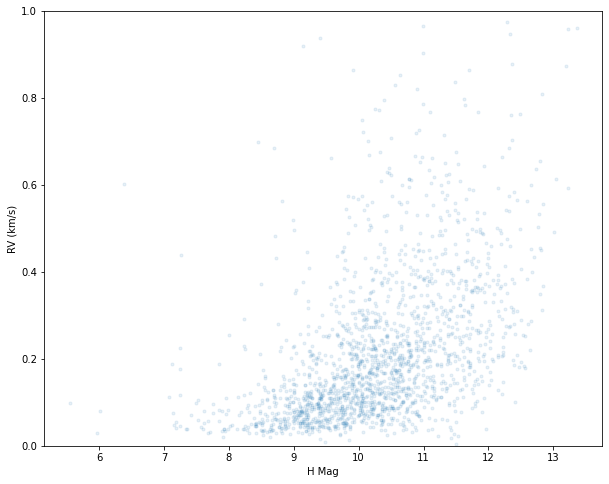

In [20]:
plt.figure(figsize=(10,8))
plt.plot(allStarGood_tab['hmag'],allStarGood_tab['vscatter'],'.',alpha=0.1)
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
plt.ylim(0,1)
plt.show()

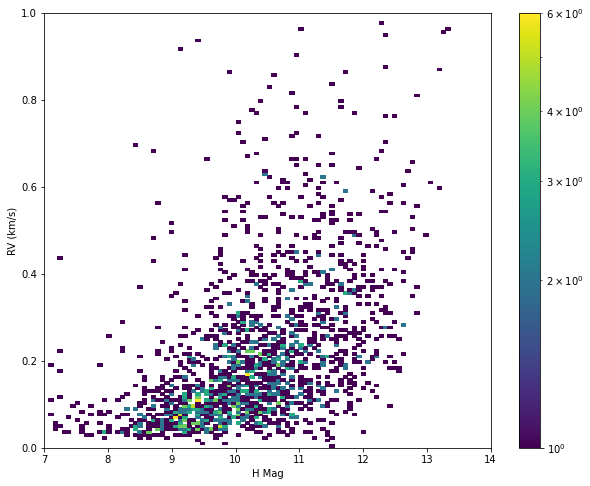

In [21]:
plt.figure(figsize=(10,8))
plt.hist2d(allStarGood_tab['hmag'],allStarGood_tab['vscatter'],bins=(100,150),range=((7,14),(0,1.0)),
           norm=mpl.colors.LogNorm())
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
#plt.yscale('log')
#plt.cscale('log')
plt.colorbar()
plt.show()

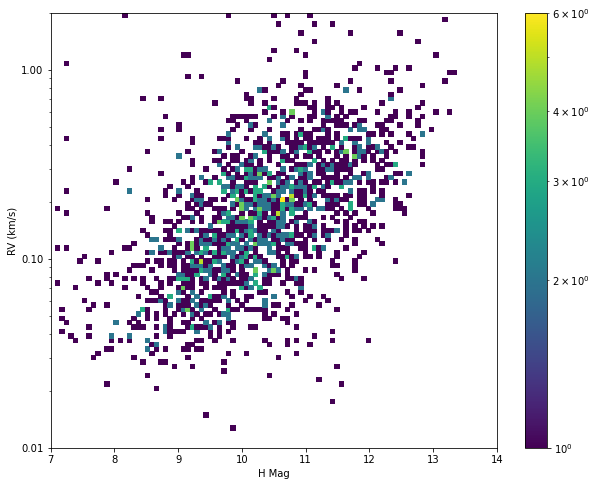

In [22]:
plt.figure(figsize=(10,8))
xbins = np.linspace(7, 14, 100)
ybins = 10**np.linspace(-2, .3, 100)
counts, _, _ = np.histogram2d(allStarGood_tab['hmag'],allStarGood_tab['vscatter'],bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
plt.yscale('log')
plt.colorbar()
plt.ylim(0.01,2)
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()

Zeropoint: 9.69 +/- 0.056


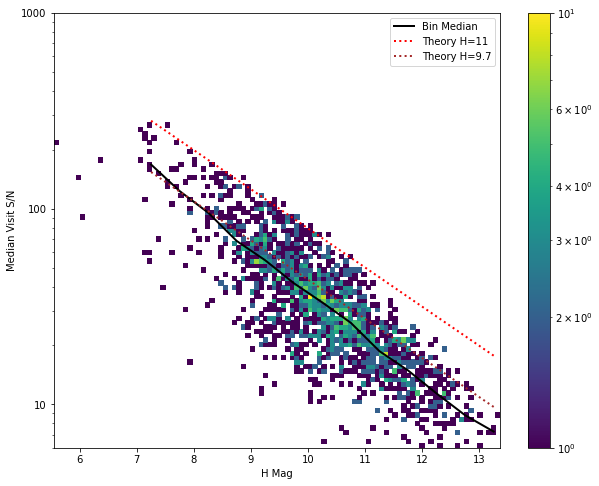

In [23]:
plt.figure(figsize=(10,8))
ybins = 10**np.linspace(np.log10(6), 3, 100)
plt.hist2d(allStarGood_tab['hmag'],allStarGood_tab['visit_med_snr'],bins=(100,ybins), \
           norm=mpl.colors.LogNorm())
xbins2 = np.linspace(7,13.5,14)
(median_arr,xbins2_arr,indice_arr) = stats.binned_statistic(allStarGood_tab['hmag'],\
                                                            allStarGood_tab['visit_med_snr'], statistic='median', \
                                                            bins=xbins2)
xbinCen_arr = (xbins2_arr[0:-1] + xbins2_arr[1:])/2
(param,cov) = curve_fit(fit_h2sn,xbinCen_arr,median_arr,p0=[11])
perr = np.sqrt(np.diag(cov))
print("Zeropoint: {:.2f} +/- {:.3f}".format(param[0],perr[0]))

plt.plot(xbinCen_arr,median_arr,lw=2,c='k', label="Bin Median")
plt.plot(xbinCen_arr,h2sn(xbinCen_arr,exptime=15),'r:',lw=2,label="Theory H=11")
plt.plot(xbinCen_arr,h2sn(xbinCen_arr,exptime=15,zeropoint=param[0]),':', c='brown',lw=2, \
         label="Theory H={:.1f}".format(param[0]))
plt.xlabel("H Mag")
plt.ylabel("Median Visit S/N")
plt.yscale('log')
plt.colorbar()
plt.legend()
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.savefig('Comm_Hvsn.png',dpi=200)
plt.show()

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


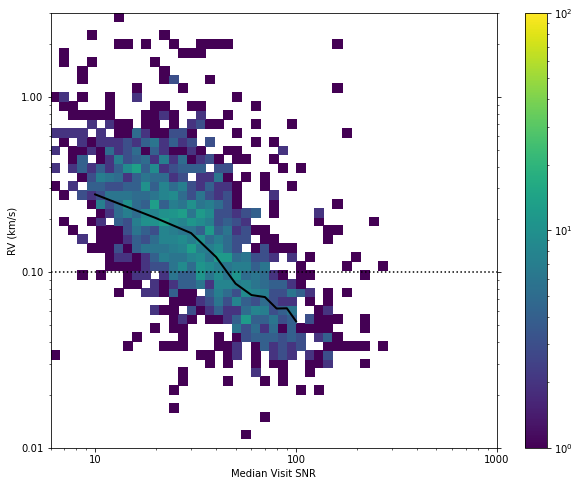

In [24]:
plt.figure(figsize=(10,8))
xbins = 10**np.linspace(np.log10(6), 3, 50)
#xbins2 = xbins[11:-2]
xbins2 = [10,20,30,40,50,60,70,80,90,100,200]
ybins = 10**np.linspace(-2,np.log10(3), 50)

(median_arr,xbins2_arr,indice_arr) = stats.binned_statistic(allStarGood_tab['visit_med_snr'],allStarGood_tab['vscatter'], statistic='median', \
                       bins=xbins2)
#xbinCen_arr = (xbins2_arr[0:-1] + xbins2_arr[1:])/2
xbinCen_arr = xbins2[0:-1]
print(xbinCen_arr)

counts, _, _ = np.histogram2d(allStarGood_tab['visit_med_snr'],allStarGood_tab['vscatter'],bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.plot(xbinCen_arr,median_arr,lw=2,c='k')
plt.xlabel("Median Visit SNR")
plt.ylabel("RV (km/s)")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.ylim(0.01,3)
plt.clim(1,100)
plt.gca().axhline(0.10,c="k",ls=":")
plt.tick_params(axis='y', which='both', left=True, right=True,labelleft=True, labelright=False)
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()

[419. 426. 301. 205. 131.  92.  67.  43.  36.  73.]


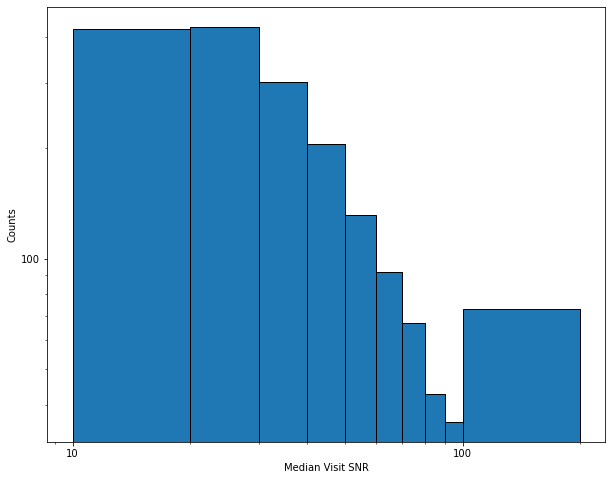

In [25]:
plt.figure(figsize=(10,8))
(counts,bins,_) = plt.hist(allStarGood_tab['visit_med_snr'],xbins2,edgecolor='k')
plt.xlabel("Median Visit SNR")
plt.ylabel("Counts")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
print(counts)

In [26]:
comm_tab = Table()
comm_tab['Visit_SNR'] = xbinCen_arr
comm_tab['RV_all'] = median_arr
comm_tab.write('commfit_all.fits',overwrite=True)
comm_tab

Visit_SNR,RV_all
int64,float64
10,0.2775692939758301
20,0.20379874110221863
30,0.16718338429927826
40,0.12209216505289078
50,0.08611566573381424
60,0.07414088398218155
70,0.0722217932343483
80,0.0621308833360672
90,0.062314532697200775


## Reproduce David's plot
1. Dwarfs: log >= 4.1
2. Subgiants: 3.5 <= log g < 4.1 (or Teff >= 5000K and 3.0 <= log g <3.5)
3. Giants: log g <= 3.0 (or Teff < 5000 K and 3.0 <= log g < 3.5).

In [27]:
david_tab = allStarSmall_tab[(allStarSmall_tab['rv_logg'] < 3.0) & (allStarSmall_tab['mysnr']>= 20) & \
    (allStarSmall_tab['ngoodvisits'] >= 3)]

david_tab

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created,visit_med_snr,mysnr
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39,float32,float32
301773,2M07593646-0002541,apStar-daily-apo25m-2M07593646-0002541-59624.fits,apogee/spectro/redux/daily/stars/apo25m/98/98218/apStar-daily-apo25m-2M07593646-0002541-59624.fits,59624,59624,59624,apo25m,daily,98218,0.0,119.902205405,-0.0483818636311,220.93340535956952,15.097198645942722,10.268,0.022,9.385,0.022,9.101,0.019,,-1.14076,-0.690011,,0,0,0,0,0,0,27021598048543377,3084059339148915200,0.106384,0.0631612,-1.14076,0.0958136,-0.690011,0.0557317,13.0691,0.00291,14.3917,0.014871,11.9467,0.007238,0,manual_fps_position_stars_10,,13,13,13,0,,0,,94.70082,0.03397739,0.009423632,0.039471086,3.0060942,3587.69,1.8563396,1.2126687,0.011539873,-0.866441,0.005344383,nan,nan,1,292.0,0.0,2022-02-18 02:29:57.885817-07,53.3216,207.0253
301786,2M07591712-0029117,apStar-daily-apo25m-2M07591712-0029117-59624.fits,apogee/spectro/redux/daily/stars/apo25m/99/99242/apStar-daily-apo25m-2M07591712-0029117-59624.fits,59624,59624,59624,apo25m,daily,99242,0.0,119.821696888,-0.486768905473,221.2937084409084,14.818819198105691,10.304,0.024,9.653,0.022,9.516,0.024,,-0.923875,0.260433,,0,0,0,0,0,0,27021598048537658,3083905991637000320,0.284664,0.0394071,-0.923875,0.0663698,0.260433,0.0443433,12.1385,0.000259,12.8306,0.001151,11.3614,0.001019,0,manual_fps_position_stars_10,,13,13,13,16,LOW_SNR,0,,68.82063,0.16347764,0.04534054,0.080758594,1.2101865,4537.821,4.9602404,2.7323525,0.015381106,-0.43849248,0.0053413603,nan,nan,1,289.0,0.0,2022-02-18 02:30:39.561152-07,15.8211,71.05373
301880,2M08011941-0055310,apStar-daily-apo25m-2M08011941-0055310-59624.fits,apogee/spectro/redux/daily/stars/apo25m/99/99755/apStar-daily-apo25m-2M08011941-0055310-59624.fits,59624,59624,59624,apo25m,daily,99755,0.0,120.331123279,-0.925608958468,221.94388693028333,15.058434062280405,9.883,0.023,9.205,0.025,8.983,0.023,,-1.09284,-0.113261,,0,0,0,0,0,0,27021598048530791,3083114373326689024,0.34611,0.0387489,-1.09284,0.0612216,-0.113261,0.0388655,11.7925,0.000321,12.5366,0.001347,10.9784,0.00072,0,manual_fps_position_stars_10,,13,13,13,0,,0,,27.56112,0.10483854,0.02907698,0.04398902,2.341758,4448.108,2.9255998,2.6719966,0.0092780655,-0.28272754,0.0033812071,nan,nan,1,175.00002,0.0,2022-02-18 02:31:38.982351-07,50.3912,208.24449
301839,2M07593150+0112313,apStar-daily-apo25m-2M07593150+0112313-59624.fits,apogee/spectro/redux/daily/stars/apo25m/96/96170/apStar-daily-apo25m-2M07593150+0112313-59624.fits,59624,59624,59624,apo25m,daily,96170,0.0,119.881769936,1.20855056601,219.77286639813144,15.670124137273817,11.237,0.026,10.417,0.021,10.235,0.02,,0.0995022,0.34782,,0,0,0,0,0,0,27021598101077580,3084781031094015360,0.0157624,0.0242808,0.0995022,0.0431977,0.34782,0.0284346,13.3645,0.000533,14.1919,0.002428,12.4847,0.0

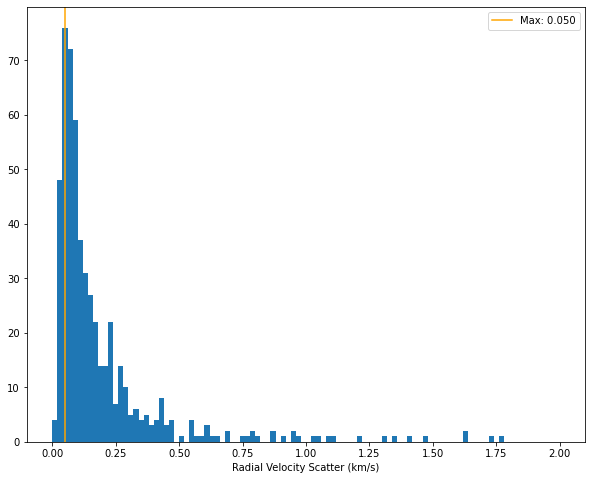

In [28]:
plt.figure(figsize=(10,8))
(counts,bins,patches) = plt.hist(david_tab['vscatter'],100,(0,2))
max_ind = np.argmax(counts)
max_cen = (bins[max_ind] + bins[max_ind+1]) /2
plt.gca().axvline(max_cen,c='orange',label='Max: {:0.3f}'.format(max_cen))
#plt.gca().axvline(0.1,c='k',label='0.1 km/s')
plt.xlabel("Radial Velocity Scatter (km/s)")
plt.legend()
plt.show()

In [29]:
david2_tab = allStarSmall_tab[(allStarSmall_tab['rv_teff'] > 4000) & (allStarSmall_tab['rv_teff'] < 4500)]
david2_tab

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created,visit_med_snr,mysnr
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes100,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39,float32,float32
301880,2M08011941-0055310,apStar-daily-apo25m-2M08011941-0055310-59624.fits,apogee/spectro/redux/daily/stars/apo25m/99/99755/apStar-daily-apo25m-2M08011941-0055310-59624.fits,59624,59624,59624,apo25m,daily,99755,0.0,120.331123279,-0.925608958468,221.94388693028333,15.058434062280405,9.883,0.023,9.205,0.025,8.983,0.023,,-1.09284,-0.113261,,0,0,0,0,0,0,27021598048530791,3083114373326689024,0.34611,0.0387489,-1.09284,0.0612216,-0.113261,0.0388655,11.7925,0.000321,12.5366,0.001347,10.9784,0.00072,0,manual_fps_position_stars_10,,13,13,13,0,,0,,27.56112,0.10483854,0.02907698,0.04398902,2.341758,4448.108,2.9255998,2.6719966,0.0092780655,-0.28272754,0.0033812071,nan,nan,1,175.00002,0.0,2022-02-18 02:31:38.982351-07,50.3912,208.24449
301839,2M07593150+0112313,apStar-daily-apo25m-2M07593150+0112313-59624.fits,apogee/spectro/redux/daily/stars/apo25m/96/96170/apStar-daily-apo25m-2M07593150+0112313-59624.fits,59624,59624,59624,apo25m,daily,96170,0.0,119.881769936,1.20855056601,219.77286639813144,15.670124137273817,11.237,0.026,10.417,0.021,10.235,0.02,,0.0995022,0.34782,,0,0,0,0,0,0,27021598101077580,3084781031094015360,0.0157624,0.0242808,0.0995022,0.0431977,0.34782,0.0284346,13.3645,0.000533,14.1919,0.002428,12.4847,0.001721,0,manual_fps_position_stars_10,,13,13,13,16,LOW_SNR,0,,72.291306,0.17187743,0.047670223,0.0694735,1.3523148,4113.764,2.4555788,2.2286062,0.011980718,-0.91379434,0.0045047733,nan,nan,1,105.0,0.0,2022-02-18 02:32:01.152544-07,20.8959,116.95933
305059,2M04291184+4119269,apStar-daily-apo25m-2M04291184+4119269-59625.fits,apogee/spectro/redux/daily/stars/apo25m/33/33120/apStar-daily-apo25m-2M04291184+4119269-59625.fits,59625,59605,59625,apo25m,daily,33120,0.0,67.2993659422,41.3240808257,160.75969414999608,-5.025487444673604,12.826,0.024,12.09,0.03,11.893,0.023,,-0.0139074,-14.0472,,0,0,0,0,0,0,27021598074587147,180127737236675200,2.87359,0.0574596,-0.0139074,0.110667,-14.0472,0.0832511,15.5154,0.000663,16.7724,0.005977,14.4087,0.002684,0,mwm_yso_pms_apogee,,17,17,17,2097152,MULTIPLE_SUSPECT,0,,4.394805,2.450467,0.5943256,0.16326307,1.1336932,4090.3997,2.8573027,4.999999,0.007725391,-0.6408102,0.0046000388,nan,nan,3,257.0,0.0,2022-02-22 09:17:26.021114-07,21.2994,96.29164
305096,2M04362747+4111288,apStar-daily-apo25m-2M04362747+4111288-59625.fits,apogee/spectro/redux/daily/stars/apo25m/33/33634/apStar-daily-apo25m-2M04362747+4111288-59625.fits,59625,59605,59625,apo25m,daily,33634,0.0,69.114478236,41.191316066,161.78651020038512,-4.1134470140799015,12.728,0.021,11.998,0.024,11.728,0.019,,3.82577,-2.88872,,0,0,0,0,0,0,27021598074441816,203855026365453056,2.11155,0.0684151,3.82577,0.145757,-2.88872,0.0760273,15.4057,0.004527,16.4685,0.020603,14.3429,0.

451
[10, 20, 30, 40, 50, 60, 70, 80, 100]
[144.  87.  32.  26.  20.  25.  11.  13.  21.]


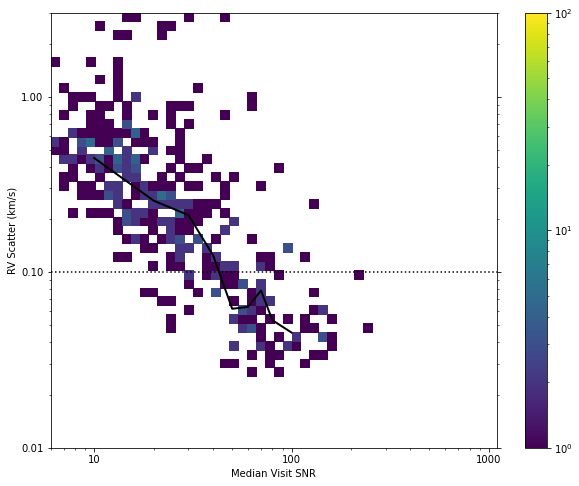

In [30]:
safe_snr_arr = david2_tab['visit_med_snr'][np.isfinite(david2_tab['visit_med_snr']) 
                                          & np.isfinite(david2_tab['vscatter'])] 
safe_rms_arr = david2_tab['vscatter'][np.isfinite(david2_tab['visit_med_snr']) 
                                          & np.isfinite(david2_tab['vscatter'])]
print(len(safe_snr_arr))

plt.figure(figsize=(10,8))
xbins = 10**np.linspace(np.log10(6), 3, 50)
#xbins2 = xbins[11:-2]
xbins2 = [10,20,30,40,50,60,70,80,100,200]
ybins = 10**np.linspace(-2,np.log10(3), 50)
xp = np.linspace(10,200)

(median_arr,xbins2_arr,indice_arr) = stats.binned_statistic(safe_snr_arr,safe_rms_arr, statistic='median', \
                       bins=xbins2)
(count_arr,_,_) = stats.binned_statistic(safe_snr_arr,safe_rms_arr, statistic='count', \
                       bins=xbins2)
#xbinCen_arr = (xbins2_arr[0:-1] + xbins2_arr[1:])/2
xbinCen_arr = xbins2[0:-1]
print(xbinCen_arr)
print(count_arr)

counts, _, _ = np.histogram2d(safe_snr_arr,safe_rms_arr,bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.plot(xbinCen_arr,median_arr,lw=2,c='k')

plt.xlabel("Median Visit SNR")
plt.ylabel("RV Scatter (km/s)")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.xlim(6,1100)
plt.ylim(0.01,3)
plt.clim(1,100)
plt.gca().axhline(0.10,c="k",ls=":")
plt.tick_params(axis='y', which='both', left=True, right=True,labelleft=True, labelright=False)
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.savefig('Comm_3visit_RVs.png',dpi=200)
plt.show()

[144.  87.  32.  26.  20.  25.  11.  13.  21.]


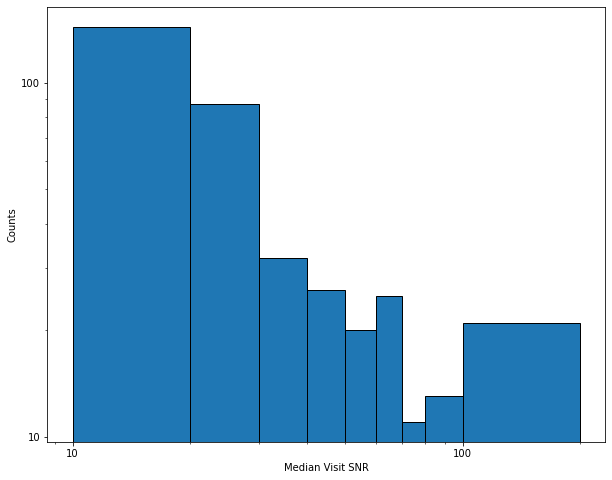

In [31]:
plt.figure(figsize=(10,8))
(counts,bins,_) = plt.hist(safe_snr_arr,xbins2,edgecolor='k')
plt.xlabel("Median Visit SNR")
plt.ylabel("Counts")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
print(counts)

## Save Analysis Results

In [32]:
drcomm_tab = Table()
drcomm_tab['Visit_SNR'] = xbinCen_arr
drcomm_tab['RV_david'] = median_arr
drcomm_tab.write('Commfit_david.fits',overwrite=True)
drcomm_tab

Visit_SNR,RV_david
int64,float64
10,0.44708627462387085
20,0.25562116503715515
30,0.2116016447544098
40,0.12490887194871902
50,0.06193007528781891
60,0.06342899799346924
70,0.07864666730165482
80,0.05326830595731735
100,0.045333027839660645
